In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
import plotly.express as px
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from forecasting_func import timeSeriesMultivariate, timeSeriesEvaluationMetrics

In [2]:
# Reading CSV dataset with ANSI encoding as it includes German Tokens

df = pd.read_csv(r"dataset/accidents.csv", encoding = "ANSI")
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunf?le,insgesamt,2021,202101,NaN,28.0,NaN,NaN,NaN
1,Alkoholunf?le,insgesamt,2021,202102,NaN,40.0,NaN,NaN,NaN
2,Alkoholunf?le,insgesamt,2021,202103,NaN,27.0,NaN,NaN,NaN
3,Alkoholunf?le,insgesamt,2021,202104,NaN,26.0,NaN,NaN,NaN
4,Alkoholunf?le,insgesamt,2021,202105,NaN,40.0,NaN,NaN,NaN


In [3]:
# Recognizing first 5 columns for further analysis

df = df.iloc[:, :5]
df = df.dropna()
df = df.iloc[::-1]
df.reset_index(inplace=True)
df = df.drop(['index'], axis = 1)
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Verkehrsunf?le,Verletzte und Get?ete,2000,200012,515.0
1,Verkehrsunf?le,Verletzte und Get?ete,2000,200011,578.0
2,Verkehrsunf?le,Verletzte und Get?ete,2000,200010,615.0
3,Verkehrsunf?le,Verletzte und Get?ete,2000,200009,675.0
4,Verkehrsunf?le,Verletzte und Get?ete,2000,200008,647.0


In [4]:
# Renaming Columns to English Counterparts for universal comprehension

df = df.rename(
    columns = {
        'MONATSZAHL':'Category',
        'AUSPRAEGUNG':'AccidentType',
        'JAHR':'Year',
        'MONAT':'Month',
        'WERT':'Value',        
    }
)
df.head()

,Category,AccidentType,Year,Month,Value
0,Verkehrsunf?le,Verletzte und Get?ete,2000,200012,515.0
1,Verkehrsunf?le,Verletzte und Get?ete,2000,200011,578.0
2,Verkehrsunf?le,Verletzte und Get?ete,2000,200010,615.0
3,Verkehrsunf?le,Verletzte und Get?ete,2000,200009,675.0
4,Verkehrsunf?le,Verletzte und Get?ete,2000,200008,647.0


In [5]:
# Basic Preprocessing to drop yearly summary value records
# More translation of Categorical Values for ease of comprehension

df.drop(df[df['Month'] == "Summe"].index, inplace = True)

for index, row in df.iterrows():
    if row['Category'] == "Alkoholunf?le":
        df['Category'][index] = "Alcohol Accidents"
    if row['Category'] == "Fluchtunf?le":
        df['Category'][index] = "Escape Accidents"
    if row['Category'] == "Verkehrsunf?le":
        df['Category'][index] = "Traffic Accidents"
    if row['AccidentType'] == "insgesamt":
            df['AccidentType'][index] = "subtotal"
    if row['AccidentType'] == "Verletzte und Get?ete":
            df['AccidentType'][index] = "injured and killed"
    if row['AccidentType'] == "mit Personensch?en":
            df['AccidentType'][index] = "with people"
        
df.head()

<ipython-input-5-1685b44ba39c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'][index] = "Traffic Accidents"
<ipython-input-5-1685b44ba39c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AccidentType'][index] = "injured and killed"
<ipython-input-5-1685b44ba39c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AccidentType'][index] = "with people"
<ipython-input-5-1685b44ba39c>:14: SettingWithCopyWarning: 
A

,Category,AccidentType,Year,Month,Value
0,Traffic Accidents,injured and killed,2000,200012,515.0
1,Traffic Accidents,injured and killed,2000,200011,578.0
2,Traffic Accidents,injured and killed,2000,200010,615.0
3,Traffic Accidents,injured and killed,2000,200009,675.0
4,Traffic Accidents,injured and killed,2000,200008,647.0


In [6]:
# Counters for each category of accidents is counted manually as the dataframe on itself cannot fully portray this information
# As the subtotal type and injured, death statistics are not mutually exclusive

ctr_alcohol = 0
ctr_escape = 0
ctr_traffic = 0

for index, row in df.iterrows():
    if row['Month'] != "Summe":
        if row["Category"] == "Alcohol Accidents" and row["AccidentType"] == "subtotal":
            ctr_alcohol += row["Value"]
        if row["Category"] == "Escape Accidents" and row["AccidentType"] == "subtotal":
            ctr_escape += row["Value"]
        if row["Category"] == "Traffic Accidents" and row["AccidentType"] == "subtotal":
            ctr_traffic += row["Value"]

# Generating dictionary for plotting
accident_nos = {
    "Alcohol Accidents": ctr_alcohol, 
    "Escape Accidents": ctr_escape, 
    "Traffic Accidents": ctr_traffic
}
print(accident_nos)

{'Alcohol Accidents': 11026.0, 'Escape Accidents': 221616.0, 'Traffic Accidents': 891374.0}


<BarContainer object of 3 artists>

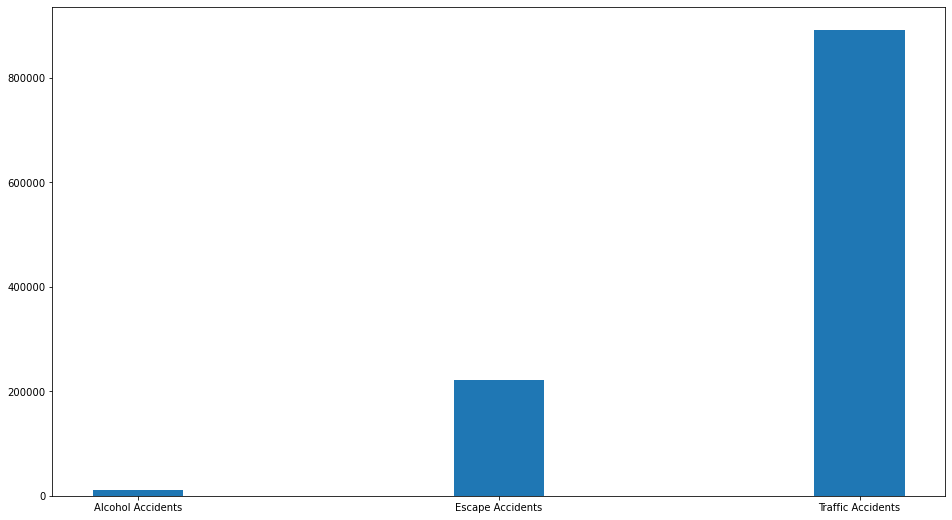

In [7]:
# Histogram Visualization

plt.figure(figsize = (16, 9))
plt.bar(accident_nos.keys(), accident_nos.values(), width=0.25)
plt.savefig("./histogram/loss_curve_1")

In [8]:
# Label Encoding Path.....

# for i in df.select_dtypes('object').columns:
#     le = LabelEncoder().fit(df[i])
#     df[i] = le.transform(df[i]) 

In [9]:
df.to_csv("./dataset/preprocessed_accidents.csv")

In [10]:
# One Hot Encoding for better results

one_hot_encoded_data = pd.get_dummies(df, columns = ['Category', 'AccidentType'])
one_hot_encoded_data = one_hot_encoded_data.iloc[:, :-1]
one_hot_encoded_data = one_hot_encoded_data.drop(['Category_Traffic Accidents'], axis = 1)
one_hot_encoded_data

,Year,Month,Value,Category_Alcohol Accidents,Category_Escape Accidents,AccidentType_injured and killed,AccidentType_subtotal
0,2000,200012,515.0,0,0,1,0
1,2000,200011,578.0,0,0,1,0
2,2000,200010,615.0,0,0,1,0
3,2000,200009,675.0,0,0,1,0
4,2000,200008,647.0,0,0,1,0
...,...,...,...,...,...,...,...
1905,2020,202005,40.0,1,0,0,1
1906,2020,202004,26.0,1,0,0,1
1907,2020,202003,27.0,1,0,0,1
1908,2020,202002,40.0,1,0,0,1


In [11]:
# More preprocessing to only get the month value from Months Column

for index, row in one_hot_encoded_data.iterrows():
    # one_hot_encoded_data.at[index, 'Month'] = row['Month'][-2:]
    # one_hot_encoded_data.at[index, 'Month'] = int(row['Month'])
    one_hot_encoded_data.at[index, 'Month'] = int(row['Month'][-2:])
    # one_hot_encoded_data.at[index, 'Year'] = int(row['Year'])
    
one_hot_encoded_data.head()

,Year,Month,Value,Category_Alcohol Accidents,Category_Escape Accidents,AccidentType_injured and killed,AccidentType_subtotal
0,2000,12,515.0,0,0,1,0
1,2000,11,578.0,0,0,1,0
2,2000,10,615.0,0,0,1,0
3,2000,9,675.0,0,0,1,0
4,2000,8,647.0,0,0,1,0


In [12]:
# new_df = one_hot_encoded_data.loc[(one_hot_encoded_data['AccidentType_subtotal'] == 1), ['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Year', 'Month', 'Value']]
# new_df

In [13]:
# # Only for insgesamt cases:
# new_df = new_df.drop('AccidentType_subtotal', axis=1)
# new_df = new_df.drop('AccidentType_injured and killed', axis=1)

# new_df

In [14]:
# fitting multivariate data for forecasting into Min Max Scalers

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

# X_df = X_scaler.fit_transform(new_df[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'Year', 'Value']])
# Y_df = Y_scaler.fit_transform(new_df[['Value']])

# X_df = X_scaler.fit_transform(one_hot_encoded_data[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Month', 'Value']])
# Y_df = Y_scaler.fit_transform(one_hot_encoded_data[['Value']]) 

X_df = X_scaler.fit_transform(one_hot_encoded_data[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Value']])
Y_df = Y_scaler.fit_transform(one_hot_encoded_data[['Value']]) 

# X_df = X_scaler.fit_transform(new_df[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'Year', 'Month', 'Value']])
# Y_df = Y_scaler.fit_transform(new_df[['Value']]) 

In [15]:
len(X_df)

1764

In [16]:
# Hyperparameters for Time Series Function Forecasting

hist_window = 36
horizon = 12
TRAIN_SPLIT = 1420
x_train, y_train = timeSeriesMultivariate(X_df, Y_df, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = timeSeriesMultivariate(X_df, Y_df, TRAIN_SPLIT, None, hist_window, horizon) 

In [17]:
print ('Multiple window of past history\n')
print(x_train[0])
print(len(x_train[0]))
print ('\n Target horizon\n')
print (y_train[0])
print(len(y_train[0]))

Multiple window of past history

[[0.         0.         1.         0.         0.10812513]
 [0.         0.         1.         0.         0.12135209]
 [0.         0.         1.         0.         0.1291203 ]
 [0.         0.         1.         0.         0.1417174 ]
 [0.         0.         1.         0.         0.13583876]
 [0.         0.         1.         0.         0.15620407]
 [0.         0.         1.         0.         0.14381692]
 [0.         0.         1.         0.         0.1417174 ]
 [0.         0.         1.         0.         0.1169431 ]
 [0.         0.         1.         0.         0.10686542]
 [0.         0.         1.         0.         0.08796977]
 [0.         0.         1.         0.         0.09111904]
 [0.         0.         1.         0.         0.10644552]
 [0.         0.         1.         0.         0.11925257]
 [0.         0.         1.         0.         0.15053538]
 [0.         0.         1.         0.         0.13499895]
 [0.         0.         1.         0.  

In [18]:
# Model Training Hyperparameters

batch_size = 32
buffer_size = 64
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [19]:
# Upgraded LSTM model with inculcated ReLU activation function as well

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True), input_shape = x_train.shape[-2:]),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = horizon),
])
lstm_model.compile(optimizer = 'adam', loss = 'mse')
lstm_model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 36, 256)           137216    
_________________________________________________________________
dense (Dense)                (None, 36, 64)            16448     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                7

In [20]:
# Model save files, callbacks, and checkpoints if necessary

model_path = "./model_path/"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 

In [21]:
# Training the model on all the above parameters and settings, excluding early stopping to attain better yield

history = lstm_model.fit(
    train_data,
    epochs = 40,
    steps_per_epoch = 100,
    validation_data = val_data,
    validation_steps = 50,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/40
100/100 [==============================] - 9s 32ms/step - loss: 0.0335 - val_loss: 0.0078


INFO:tensorflow:Assets written to: ./model_path\assets


INFO:tensorflow:Assets written to: ./model_path\assets


Epoch 2/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0418 - val_loss: 0.1468
Epoch 3/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0298 - val_loss: 0.0114
Epoch 4/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0222 - val_loss: 0.0020


INFO:tensorflow:Assets written to: ./model_path\assets


INFO:tensorflow:Assets written to: ./model_path\assets


Epoch 5/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0167 - val_loss: 0.0097
Epoch 6/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0155 - val_loss: 0.0294
Epoch 7/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0104 - val_loss: 0.0127
Epoch 8/40
100/100 [==============================] - 2s 23ms/step - loss: 0.0112 - val_loss: 0.0066
Epoch 9/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0135 - val_loss: 0.0113
Epoch 10/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0111 - val_loss: 0.0146
Epoch 11/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 12/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0120 - val_loss: 0.0018


INFO:tensorflow:Assets written to: ./model_path\assets


INFO:tensorflow:Assets written to: ./model_path\assets


Epoch 13/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0138 - val_loss: 0.0027
Epoch 14/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 15/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0096 - val_loss: 0.0118
Epoch 16/40
100/100 [==============================] - 2s 21ms/step - loss: 0.0113 - val_loss: 0.0024
Epoch 17/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0121 - val_loss: 0.0018
Epoch 18/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 19/40
100/100 [==============================] - 2s 21ms/step - loss: 0.0096 - val_loss: 0.0151
Epoch 20/40
100/100 [==============================] - 2s 21ms/step - loss: 0.0107 - val_loss: 0.0156
Epoch 21/40
100/100 [==============================] - 2s 22ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 22/40
100/100 [==============================] - 2s 21ms/step - loss: 0.0087

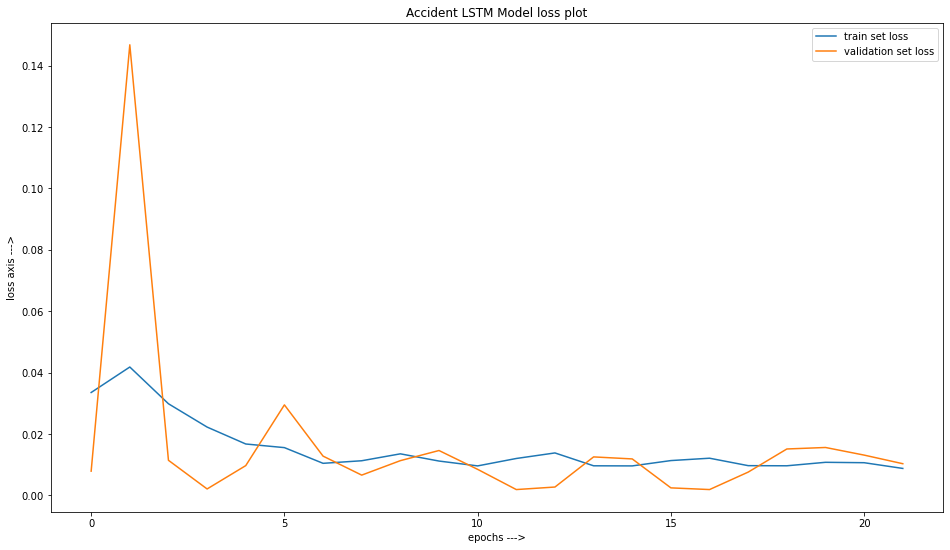

In [22]:
# plotting Loss accross epochs

plt.figure(figsize = (16, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Accident LSTM Model loss plot')
plt.ylabel('loss axis --->')
plt.xlabel('epochs --->')
plt.legend(['train set loss', 'validation set loss'])
plt.savefig("./plots/loss_curve_1")
plt.show()

In [23]:
# Saving model

lstm_model.save('./models/GermanAccidents_11.h5')
lstm_model.save('./models/GermanAccidentsWeights_11.h5')

In [ ]:
# Loading Model

loadedModel = load_model('./models/GermanAccidents_10.h5')
loadedModel.summary()

In [29]:
# preparing data of last 36 months for prediction analysis

# data_val = X_scaler.fit_transform(new_df[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'Year', 'Value']].tail(36))
data_val = X_scaler.fit_transform(one_hot_encoded_data[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Value']].tail(36))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
# pred
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse[0]

array([1422.1453, 1559.1423, 1485.9961, 1558.5616, 1599.352 , 1609.8003,
       1467.0275, 1580.1118, 1688.9159, 1629.0812, 1322.1194, 1419.9089],
      dtype=float32)

In [30]:
# Displaying accident records of last 36 months for correlation analysis

# new_df[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'Year', 'Value']].tail(36)
one_hot_encoded_data[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Value']].tail(36)

,Category_Alcohol Accidents,Category_Escape Accidents,AccidentType_injured and killed,AccidentType_subtotal,Value
1872,1,0,0,1,21.0
1873,1,0,0,1,31.0
1874,1,0,0,1,43.0
1875,1,0,0,1,36.0
1876,1,0,0,1,40.0
1877,1,0,0,1,51.0
1878,1,0,0,1,39.0
1879,1,0,0,1,34.0
1880,1,0,0,1,25.0
1881,1,0,0,1,32.0


## Forecasting for the next 12 months (year: 2021) 

In [27]:
print("January: ", int(pred_Inverse[0][0]))
print("Febuary: ", int(pred_Inverse[0][1]))
print("March: ", int(pred_Inverse[0][2]))
print("April: ", int(pred_Inverse[0][3]))
print("May: ", int(pred_Inverse[0][4]))
print("June: ", int(pred_Inverse[0][5]))
print("July: ", int(pred_Inverse[0][6]))
print("August: ", int(pred_Inverse[0][7]))
print("September: ", int(pred_Inverse[0][8]))
print("October: ", int(pred_Inverse[0][9]))
print("November: ", int(pred_Inverse[0][10]))
print("December: ", int(pred_Inverse[0][11]))

January:  1422
Febuary:  1559
March:  1485
April:  1558
May:  1599
June:  1609
July:  1467
August:  1580
September:  1688
October:  1629
November:  1322
December:  1419
